In [1]:
import sys
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import json
from collections import Counter
from tqdm import tqdm

In [2]:
sys.path.append("..") # adds twitter_sentiment path

In [3]:
from twitter_sentiment.preprocessors.utils import read_jsonlines_lzma
from twitter_sentiment.graph.utils import load_graph

## Selects a small group of users to compose the test dataset

In [4]:
g = load_graph("../data/output/all-edgelist.csv", prune_scc=True)
scc_users = list(g.vp["user_ids"])

2020-11-03 14:39:33,469 twitter_sentiment [INFO]: Loading file and counting retweets...
2020-11-03 14:40:33,579 twitter_sentiment [INFO]: Adding edge list to graph...


In [5]:
len(scc_users)

236814

In [6]:
dataset = "../data/output/all_deduplicated-pt.jsonline.xz"
tweets = read_jsonlines_lzma(dataset)

In [7]:
users = Counter()
for t in tweets:
    users[t["user_id"]] += 1

In [8]:
df = pd.DataFrame(users.most_common(), columns=["user", "tweets"])
df["in_scc"] = df.user.isin(scc_users)
df

,user,tweets,in_scc
0,2389885888,4712,False
1,255537739,4166,True
2,925408861690978304,2885,True
3,32004682,2837,True
4,2151270211,2201,False
...,...,...,...
1959941,329381126,1,False
1959942,40025762,1,False
1959943,45826445,1,False
1959944,1184578801860251649,1,False


In [9]:
df.in_scc.cumsum()[8000]

6530

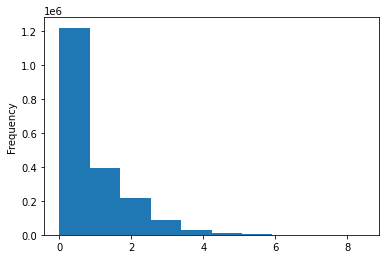

In [10]:
np.log(df.tweets).plot.hist()

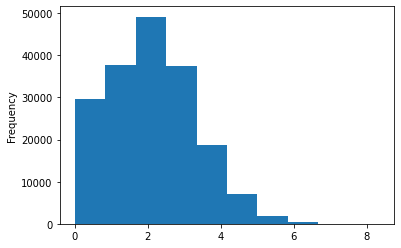

In [11]:
np.log(df.loc[df.in_scc == True, "tweets"]).plot.hist()

In [12]:
selected_users = df.loc[df.in_scc == True, :].head(10000)

In [13]:
sampled_users = selected_users.sample(500, random_state=7)

In [14]:
sampled_users_ids = set(sampled_users.user.to_list())
sampled_users_ids

{'1000501811437023232',
 '100118271',
 '1004097971217190913',
 '1005584386274873345',
 '1005942277989072898',
 '1007647339945844739',
 '1008031980829671426',
 '1008687530080907264',
 '1009148548380872711',
 '1009266113438511105',
 '1009404029158518784',
 '101447949',
 '1014626616176271360',
 '1017156825282760705',
 '1017890266353750018',
 '1019294488580247554',
 '1019540810105348096',
 '1019578724017233921',
 '1020242876997959680',
 '102056466',
 '1021569169735725057',
 '102194323',
 '1023404755140399104',
 '1025745856111235073',
 '1028495667935805440',
 '1031677047473623040',
 '1039673096125460480',
 '1048970159300509696',
 '1049395270520381440',
 '105193728',
 '1053865990990323718',
 '1056323861476720642',
 '1058037388130299904',
 '1058408849303134208',
 '1068095869013172224',
 '1072571145994539008',
 '107529978',
 '1078280105854681088',
 '1078478554411794433',
 '1079068216784236544',
 '109025123',
 '1091691201844207617',
 '1093339655523782656',
 '1093567069201842178',
 '109543450789

## Funcao que joga para doccano

In [31]:
dataset = "../data/output/all_deduplicated-pt.jsonline.xz"
tweets = read_jsonlines_lzma(dataset)

In [32]:
def to_doccano(tweet):
    meta = {"id": tweet["id"], "user_id": tweet["user_id"]}
    return json.dumps({"text": tweet["text"], "meta": meta})

In [33]:
with open("tmp/doccano_input.jsonl", "w") as fout:
    for tweet in tqdm(tweets):
        if tweet["user_id"] in sampled_users_ids:
            fout.write(to_doccano(tweet))
            fout.write("\n")

9195192it [01:21, 112787.78it/s]


In [34]:
# shuffle with fixed seed
doc = pd.read_json("tmp/doccano_input.jsonl", lines=True)
doc.sample(frac=1, random_state=7).to_json("tmp/doccano_input.jsonl", orient='records', lines=True)

In [35]:
!split -d -l 1000 tmp/doccano_input.jsonl tmp/doccano_input.jsonl.